# Ungraded Lab: Effect of Compacted Images in Training

In this notebook, you will see how reducing the target size of the generator images will affect the architecture and performance of your model. This is a useful technique in case you need to speed up your training or save compute resources. Let's begin!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

As before, start downloading the train and validation sets:

In [1]:
# Install packages for compatibility

# NOTE: You can safely ignore errors about version incompatibility of
# Colab-bundled packages (e.g. xarray, pydantic, etc.)

#!pip install tf-keras==2.15 --quiet
#!pip install tensorflow==2.15 --quiet
#!pip install keras==2.15 --quiet

In [2]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2025-03-26 00:34:27--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  21.9MB/s    in 7.8s    

2025-03-26 00:34:35 (18.2 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [3]:
# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2025-03-26 00:34:35--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘validation-horse-or-human.zip’

validation-horse-or 100%[===================>]  10.95M  6.88MB/s    in 1.6s    

2025-03-26 00:34:37 (6.88 MB/s) - ‘validation-horse-or-human.zip’ saved [11480187/11480187]



Then unzip them:

In [4]:
import zipfile

# Unzip training set
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')

# Unzip validation set
local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation-horse-or-human')

zip_ref.close()

Then define the directories containing the images:

In [5]:
import os

# Directory with training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./validation-horse-or-human/humans')

You can check that the directories are not empty and that the train set has more images than the validation set:

In [6]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_hames = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_hames[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

TRAIN SET HORSES: ['horse31-6.png', 'horse49-1.png', 'horse50-0.png', 'horse34-1.png', 'horse45-8.png', 'horse32-4.png', 'horse06-5.png', 'horse44-3.png', 'horse17-0.png', 'horse08-5.png']
TRAIN SET HUMANS: ['human10-09.png', 'human01-19.png', 'human13-09.png', 'human14-15.png', 'human14-05.png', 'human07-07.png', 'human17-22.png', 'human07-05.png', 'human04-04.png', 'human11-17.png']
VAL SET HORSES: ['horse1-122.png', 'horse4-345.png', 'horse4-102.png', 'horse2-383.png', 'horse5-235.png', 'horse6-004.png', 'horse3-484.png', 'horse4-503.png', 'horse1-224.png', 'horse5-076.png']
VAL SET HUMANS: ['valhuman04-17.png', 'valhuman04-03.png', 'valhuman03-09.png', 'valhuman05-06.png', 'valhuman01-14.png', 'valhuman05-11.png', 'valhuman04-07.png', 'valhuman01-01.png', 'valhuman03-22.png', 'valhuman03-08.png']


In [7]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


## Build the Model

The model will follow the same architecture as before but they key difference is in the `input_shape` parameter of the first `Conv2D` layer. Since you will be compacting the images later in the generator, you need to specify the expected image size here. So instead of 300x300 as in the previous two labs, you specify a smaller 150x150 array.

In [14]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

class Model:
    def __init__(self, input_shape, filters, kernel_size, pool_size):
        self.input_shape = input_shape
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # Convolution layers
        for idx, f in enumerate(self.filters):
            if idx == 0:
                model.add(Conv2D(filters=f, kernel_size=self.kernel_size, activation='relu', input_shape=self.input_shape))
                model.add(MaxPooling2D(pool_size=self.pool_size))
            else:
                model.add(Conv2D(filters=f, kernel_size=self.kernel_size, activation='relu'))
                model.add(MaxPooling2D(pool_size=self.pool_size))
        # Flatten the results to feed into a DNN
        model.add(Flatten())
        # 512 neuron hidden layer
        model.add(Dense(units=512, activation='relu'))
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
        model.add(Dense(units=1, activation='sigmoid'))
        return model

    def compile_model(self, loss='mse', optimizer=SGD(learning_rate=1e-6, momentum=0.9), metrics=None):
        self.model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=metrics if metrics else []
        )

    def train_model(self, dataset, steps_per_epoch=10, num_epochs=30, validation_data=None, validation_steps=None, callbacks=None, verbose=1):
        history = self.model.fit(
            dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            validation_data = validation_data,
            validation_steps = validation_steps,
            callbacks=callbacks if callbacks else [],
            verbose=verbose
        )
        return history

    def summary_model(self):
        self.model.summary()

    def prediction_model(self, data, batch_size, verbose=0):
        predictions = self.model.predict(data, batch_size=batch_size, verbose=verbose)
        return predictions

In [15]:
input_shape = (150, 150, 3)
filters = [16, 32, 64, 64, 64]
# filters = [16, 32, 64] # (You can comment the 4th and 5th conv layers later to see how it affects the results
kernel_size = (3, 3)
pool_size = (2, 2)

# Create an instance of the Model class
model = Model(input_shape, filters, kernel_size, pool_size)

You can see the difference from previous models when you print the `model.summary()`. As expected, there will be less inputs to the `Dense` layer at the end of the model compared to the previous labs. This is because you used the same number of max pooling layers in your model. And since you have a smaller image to begin with (150 x 150), then the output after all the pooling layers will also be smaller.

In [16]:
model.summary_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 229,537 (896.63 KB)

 Trainable params: 229,537 (896.63 KB)

 Non-trainable params: 0 (0.00 B)

You will use the same settings for training:

In [17]:
from tensorflow.keras.optimizers import RMSprop

model.compile_model(loss='binary_crossentropy',
                    optimizer=RMSprop(learning_rate=0.001),
                    metrics=['accuracy'])

### Data Preprocessing

Now you will instantiate the data generators. As mentioned before, you will be compacting the image by specifying the `target_size` parameter. See the simple change below:

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since you used binary_crossentropy loss, you need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since you used binary_crossentropy loss, you need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Training

Now you're ready to train and see the results. Note your observations about how fast the model trains and the accuracies you're getting in the train and validation sets.

In [19]:
history = model.train_model(
      train_generator,
      steps_per_epoch=8,
      num_epochs=30,
      validation_data=validation_generator,
      validation_steps=8,
      verbose=1)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5334 - loss: 0.6914 - val_accuracy: 0.6523 - val_loss: 0.6608
Epoch 2/30
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7578 - loss: 0.6577

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.7578 - loss: 0.6577 - val_accuracy: 0.5000 - val_loss: 0.8716
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 796ms/step - accuracy: 0.6035 - loss: 0.6750 - val_accuracy: 0.5000 - val_loss: 1.3491
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.4922 - loss: 1.0567 - val_accuracy: 0.5820 - val_loss: 0.5760
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 814ms/step - accuracy: 0.7080 - loss: 0.5649 - val_accuracy: 0.7383 - val_loss: 0.6147
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.7344 - loss: 0.4623 - val_accuracy: 0.7461 - val_loss: 0.6413
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 965ms/step - accuracy: 0.7538 - loss: 0.4289 - val_accuracy: 0.8359 - val_loss: 0.4160
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8828 - loss: 0.3315 - val_accuracy: 0.8359 - val_loss: 0.4997
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 781ms/step - accuracy: 0.8998 - loss: 0.2699 - val_accuracy: 0.8594 - val_loss: 0.3446
Epo

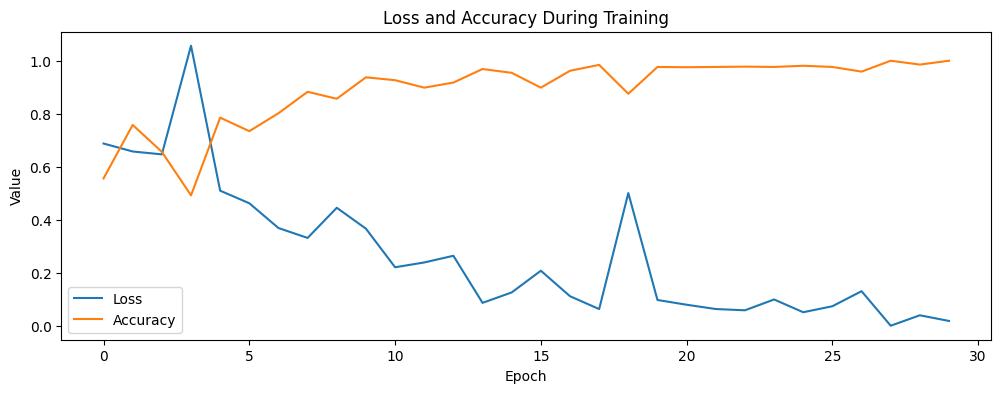

In [20]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
def plot_accuracy_loss(history):
  plt.figure(figsize=(12, 4))

  plt.plot(history.history['loss'], label='Loss')
  plt.plot(history.history['accuracy'], label='Accuracy')
  plt.title('Loss and Accuracy During Training')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

plot_accuracy_loss(history)

### Model Prediction

As usual, it is also good practice to try running your model over some handpicked images. See if you got better, worse, or the same performance as the previous lab.

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

In [22]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


Saving horse-1.jpg to horse-1 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
[0.99972814]
horse-1 (1).jpg is a human


If you're using Safari and the cell above throws an error, you will need to upload the images(s) manually in their workspace.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below.

In [ ]:
# # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#  print()
#  # predicting images
#  path = '/tmp/images/' + i
#  img = load_img(path, target_size=(150, 150))
#  x = img_to_array(img)
#  x /= 255
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a human")
#  else:
#    print(i + " is a horse")

### Visualizing Intermediate Representations

You can also look again at the intermediate representations. You will notice that the output at the last convolution layer is even more abstract because it contains fewer pixels than before.

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow as tf

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

AttributeError: The layer sequential_1 has never been called and thus has no defined input.

## Clean Up

Please run the following cell to terminate the kernel and free memory resources:

In [24]:
from google.colab import runtime
runtime.unassign()

## Wrap Up

In this lab, you saw how compacting images affected your previous model. This is one technique to keep in mind especially when you are still in the exploratory phase of your own projects. You can see if a smaller model behaves just as well as a large model so you can have faster training. You also saw how easy it is to customize your images for this adjustment in size by simply changing a parameter in the `ImageDataGenerator` class.